# Description
- predict the strain gauges with the input (omega, acc, sgc)
- subtract prediction in the fft space 
    - Use CVXpy to solve for best coefficient c of for each snow type and each strain gauge. 
    - Obtain this coefficient by solving the cvx problem Ax = b, where A is the input and B is the output.
    - Append these cofficients to the fft of each strain gauge and snow type.
        - Note that the coefficient will be the same for every ski run (fast/slow)
- take the svd of the fft data with the coefficients appended
    - plot in the U-bases.

## Pckages

In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from scipy import fft
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pylab as pl # Use this for plotting with numbers as markers.

# Use stats models to predict more complex combinations of predictors.
import statsmodels.api as sm
import statsmodels.formula.api as smf

import math
import pynumdiff
import cvxpy as cp

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

import sympy
from sympy.physics.mechanics import ReferenceFrame, inertia
from sympy.vector import CoordSys3D, BodyOrienter

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics

2023-07-27 10:14:35,483 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



## Functions

In [2]:
# def fft_of_data(data,dt):
#     N = data.shape[0] # Length of data.
#     raw = 2.0/N * fft.fft(data)[0:N//2]
#     yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the manitude to the magnitude of the orginal sinewave.
#     # Remember the the y-data will be complex so you have to take the absolute value.
#     xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
#     phase = np.angle(raw)
#     magnitude = np.abs(raw)
#     return(xf, yf, phase, magnitude)

def fft_of_data(data,dt,noise_param):
    N = data.shape[0] # Length of data.
    raw = 2.0/N * fft.fft(data)[0:N//2]
#     raw = fft.fft(data)
    yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the manitude to the magnitude of the orginal sinewave.
    # Remember the the y-data will be complex so you have to take the absolute value.
    xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
#     phase = np.angle(raw)
    phase = denoise_phase(raw,noise_param)
    magnitude = np.abs(raw)
    return(xf, yf, phase, magnitude, raw)

# Remove the noise from the phase data. Noise occurs because some of the numbers are extremely small.
def denoise_phase(X,noise_param):
    X2=X #store the FFT results in another array
    #detect noise (very small numbers (eps)) and ignore them
    threshold = max(abs(X))/noise_param #tolerance threshold; originally=10000
    X2[abs(X)<threshold] = 0 #maskout values that are below the threshold
    
    phase = []
    for i in range(len(X2)):
        A = math.atan2(X2.imag[i],X2.real[i])*180/np.pi
        phase.append(A)

    phase = np.vstack(phase)
    return(phase)

def full_fft(data,dt):
    N = data.shape[0] # length of data.
    yf = fft.fft(data)
    xf = fft.fftfreq(N, dt)
    
    return(xf, yf)

# Use query to extract segments of data.
def segment_data(df, column_title, lower_lim, upper_lim):
    q = column_title + ' < ' + str(upper_lim) + ' and ' + column_title + ' > ' + str(lower_lim)
    new_df = df.query(q)
    return(new_df)

def linregress_residual_strain(df, predictor, labels):
    res = []
    x = np.array(df[predictor])
    for i in labels:
        y = np.array(df[i])
        model = stats.linregress(x,y)
        predicted_strain = x*model.slope + model.intercept
        res_strain = y - predicted_strain
        res.append(res_strain)
    
    res = np.vstack(res)
    
    return(res)

# segment_data_2turns segments the data based on an index value that contains at least two turns from the slowest data. 
def segment_data_2turns(df,t_id,column):
    B = []
    k = 0
    for i in range(df.shape[0]//t_id):
        A = []
        for j in range(t_id):
            A.append(df.iloc[k,column])
            k = k+1
            
        B.append(A)
    B = np.vstack(B).T
    return(B)

def segment_data_2turns_nodf(array,t_id,column):
    # Must be a column array.
    B = []
    k = 0
    for i in range(array.shape[0]//t_id):
        A = []
        for j in range(t_id):
            A.append(array[k,column])
            k = k+1
            
        B.append(A)
    B = np.vstack(B).T
    return(B)

def sig_norm(signal):
    signal_mean = np.mean(signal)
    signal_std = np.std(signal)
    signal_norm = (signal-signal_mean)/signal_std
    return(signal_norm)

# Smooth your data like butter.
def smooth_butter(df, params, dt, col_names):
    for i in range(np.size(col_names)):
        df[col_names[i] + '_hat'], df[col_names[i] + '_dt'] = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
    return(df)

# Smooth your data and return only smooth signals.
def smooth_only(df, params, dt, col_names):
    df_new = pd.DataFrame()
    for i in range(len(col_names)):
        smooth_data, smooth_derivative = pynumdiff.smooth_finite_difference.butterdiff(df[col_names[i]], dt, params, options={'iterate': False})
        df_new[col_names[i]] = smooth_data 
    return(df_new)

In [3]:
def sig_norm_df(df, columns):
    df_norm = pd.DataFrame(columns=columns)
    for i in range(len(columns)):
        signal = df[columns[i]]
        signal_mean = np.mean(signal)
        signal_std = np.std(signal)
        signal_norm = (signal-signal_mean)/signal_std
        df_norm[columns[i]] = signal_norm
    
    return(df_norm)

def sig_mean_df(df, columns,time):
    df_mean = pd.DataFrame(columns=columns)
    for i in range(len(columns)):
        signal = df[columns[i]]
        signal_mean = np.mean(signal)
        signal_use = (signal-signal_mean)
        df_mean[columns[i]] = signal_use
    df_mean[time] = df[time]
    
    return(df_mean)



In [4]:
def fft_of_data_df(df,dt,columns):
    fft_df = pd.DataFrame()
    for i in range(len(columns)):
        data = df[columns[i]]
        data = np.array(data)
        N = data.shape[0] # Length of data.
        yf = 2.0/N * np.abs(fft.fft(data)[0:N//2])# Divide to bring the manitude to the magnitude of the orginal sinewave.
        # Remember the the y-data will be complex so you have to take the absolute value.
        xf = fft.fftfreq(N,dt)[:N//2]# Only take the first half of the data.
        fft_df[columns[i]+'_fft'] = yf
        if i == len(columns)-1:
            fft_df['Frequency'] = xf
    return(fft_df)

def simple_fft_array(array,dt):
    fft_df = pd.DataFrame()
    N = np.shape(array)[0]
    yf = 2.0/N * np.abs(fft.fft(array)[0:N//2])
    xf = fft.fftfreq(N,dt)[:N//2]
    fft_df['array_fft'] = yf
    fft_df['frequency'] = xf
    return(fft_df)

def arrange_full_runs_by_sg(list_of_dfs,strain_gauge):
    new_df = pd.DataFrame()
    for i in range(len(list_of_dfs)):
            new_df[strain_gauge+str(i)] = list_of_dfs[i][strain_gauge]
    return(new_df)

In [5]:
def get_cvx_coef(A,b):
    x = cp.Variable([np.shape(A)[1],1])
    objective = cp.Minimize(cp.sum_squares(A @ x-b))
    prob = cp.Problem(objective)
    
    result = prob.solve()
    coeff = pd.Series(x.value[0])
    return(coeff)

def segment_create_new_df_for_each_sg(list_of_dfs,strain_gauge,chunck_size,snow_types,dt):
    lower_freq = 1/60
    high_freq = 150
    df_new = pd.DataFrame()
#     dataframes = np.shape(list_of_dfs[0])[0]
    data_frames = len(snow_types)-1
    for j in range(data_frames):
            df_column = list_of_dfs[j][strain_gauge]
            n = len(df_column)//chunk_size
            for i in range(n):
                data = df_column[i*chunk_size:(i+1)*chunk_size] # "data" is the segmented timeseries. 
                df_new[df_column.name+'_'+str(i+1)+'_'+snow_types[j]] = data.reset_index(drop=True)
    df_new = fft_of_data_df(df_new,dt,df_new.columns.tolist())
    # Take every 5th entry.
    df_new = segment_data(df_new,'Frequency',lower_freq,high_freq) #.iloc[0::2,:].reset_index(drop=True)
    return(df_new)

## Code

## Formatting data.
- Upload data and make each ski run the same length
- Smooth the data and fft the data

In [6]:
# Import ski data
df_grmr = pd.read_hdf('DATA/df_grmr.hdf')
df_grmr1 = pd.read_hdf('DATA/df_grmr1.hdf')
df_grmr2 = pd.read_hdf('DATA/df_grmr2.hdf')
df_grmr3 = pd.read_hdf('DATA/df_grmr3.hdf')
df_grmr4 = pd.read_hdf('DATA/df_grmr4.hdf')
df_grmr5 = pd.read_hdf('DATA/df_grmr5.hdf')

df_pwdr = pd.read_hdf('DATA/df_pwdr.hdf')
df_pwdr1 = pd.read_hdf('DATA/df_pwdr1.hdf')

df_icy = pd.read_hdf('DATA/df_icy.hdf')

df_s = pd.read_hdf('DATA/df_s.hdf')
df_s1 = pd.read_hdf('DATA/df_s1.hdf')
df_s2 = pd.read_hdf('DATA/df_s2.hdf')
df_s3 = pd.read_hdf('DATA/df_s3.hdf')


In [7]:
df_total = [df_grmr,df_grmr1,df_grmr2,df_grmr3,df_grmr4,df_grmr5,df_pwdr,df_pwdr1,df_icy,df_s,df_s1,df_s2,df_s3]

In [8]:
columns = ['sg3','sg4','sg6','sgc','sg7','sg12','sg15','imu_ax','imu_ay','imu_az','imu_wx','imu_wy','imu_wz']
# Create dataframes that are normalized: mean subtracted and divided by the standard deviation.
df_grmr_norm  = sig_norm_df(df_grmr,columns)
df_grmr1_norm = sig_norm_df(df_grmr1,columns)
df_grmr2_norm = sig_norm_df(df_grmr2,columns)
df_grmr3_norm = sig_norm_df(df_grmr3,columns)
df_grmr4_norm = sig_norm_df(df_grmr4,columns)
df_grmr5_norm = sig_norm_df(df_grmr5,columns)
df_pwdr_norm  = sig_norm_df(df_pwdr,columns)
df_pwdr1_norm = sig_norm_df(df_pwdr1,columns)
df_icy_norm   = sig_norm_df(df_icy,columns)
df_s_norm     = sig_norm_df(df_s,columns)
df_s1_norm    = sig_norm_df(df_s1,columns)
df_s2_norm    = sig_norm_df(df_s2,columns)
df_s3_norm    = sig_norm_df(df_s3,columns)

all_norm_time = [df_grmr_norm,df_grmr1_norm,df_grmr2_norm,df_grmr3_norm,df_grmr4_norm,df_grmr5_norm,
                df_pwdr_norm,df_pwdr1_norm,
                df_icy_norm,
                df_s_norm,df_s1_norm,df_s2_norm,df_s3_norm]

# Create data frames that are mean subtracted.
df_grmr_mean  = sig_mean_df(df_grmr,columns,'time_imu')
df_grmr1_mean = sig_mean_df(df_grmr1,columns,'time_imu')
df_grmr2_mean = sig_mean_df(df_grmr2,columns,'time_imu')
df_grmr3_mean = sig_mean_df(df_grmr3,columns,'time_imu')
df_grmr4_mean = sig_mean_df(df_grmr4,columns,'time_imu')
df_grmr5_mean = sig_mean_df(df_grmr5,columns,'time_imu')
df_pwdr_mean  = sig_mean_df(df_pwdr,columns,'time_imu')
df_pwdr1_mean = sig_mean_df(df_pwdr1,columns,'time_imu')
df_icy_mean   = sig_mean_df(df_icy,columns,'time_imu')
df_s_mean     = sig_mean_df(df_s,columns,'time_imu')
df_s1_mean    = sig_mean_df(df_s1,columns,'time_imu')
df_s2_mean    = sig_mean_df(df_s2,columns,'time_imu')
df_s3_mean    = sig_mean_df(df_s3,columns,'time_imu')
all_mean_time = [df_grmr_mean,df_grmr1_mean,df_grmr2_mean,df_grmr3_mean,df_grmr4_mean,df_grmr5_mean,
                df_pwdr_mean,df_pwdr1_mean,
                df_icy_mean,
                df_s_mean,df_s1_mean,df_s2_mean,df_s3_mean]

In [9]:
# Define DT early.
dt = df_grmr.time_imu[10]-df_grmr.time_imu[9]

In [10]:
dt

0.0009999999999763531

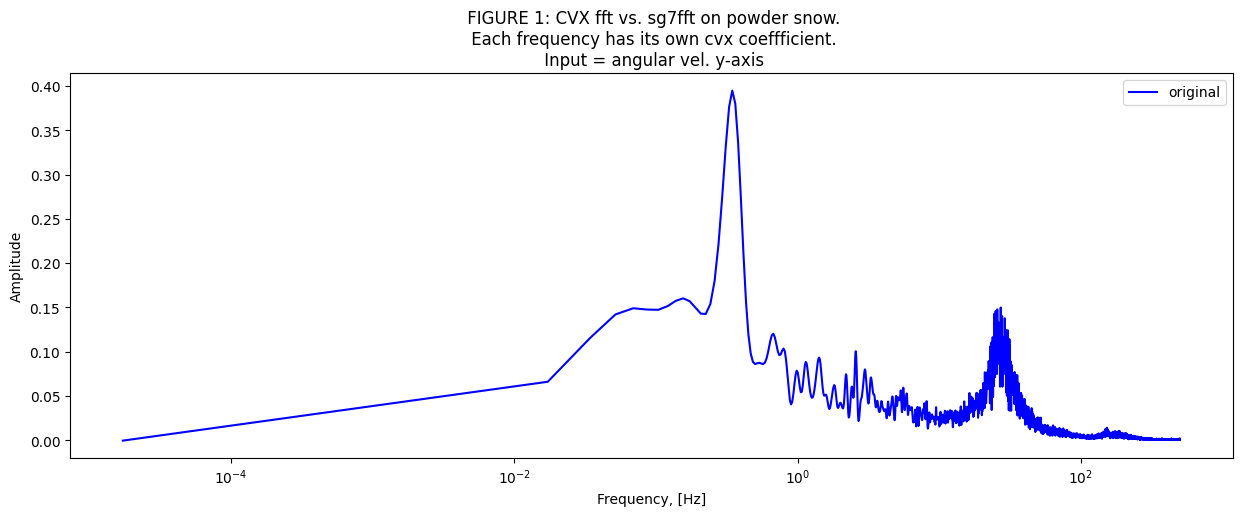

In [11]:
columns = ['sg3','sg4','sg6','sgc','sg7','sg12','sg15','imu_ax','imu_ay','imu_az','imu_wx','imu_wy','imu_wz']

# FFT of non-normalized strain data.
df_grmr_fft = fft_of_data_df(df_grmr_mean,dt,columns)
df_grmr1_fft = fft_of_data_df(df_grmr1_mean,dt,columns)
df_grmr2_fft = fft_of_data_df(df_grmr2_mean,dt,columns)
df_grmr3_fft = fft_of_data_df(df_grmr3_mean,dt,columns)
df_grmr4_fft = fft_of_data_df(df_grmr4_mean,dt,columns)
df_grmr5_fft = fft_of_data_df(df_grmr5_mean,dt,columns)
df_pwdr_fft = fft_of_data_df(df_pwdr_mean,dt,columns)
df_pwdr1_fft = fft_of_data_df(df_pwdr1_mean,dt,columns)
df_icy_fft = fft_of_data_df(df_icy_mean,dt,columns)
df_s_fft = fft_of_data_df(df_s_mean,dt,columns)
df_s1_fft = fft_of_data_df(df_s1_mean,dt,columns)
df_s2_fft = fft_of_data_df(df_s2_mean,dt,columns)
df_s3_fft = fft_of_data_df(df_s3_mean,dt,columns)
all_raw_fft_dataframes = [df_grmr_fft,df_grmr1_fft,df_grmr2_fft,df_grmr3_fft,df_grmr4_fft,df_grmr5_fft,
                         df_pwdr_fft,df_pwdr1_fft,
                         df_icy_fft,
                         df_s_fft,df_s1_fft,df_s2_fft,df_s3_fft]

# Take the fft of all the normalized columns
df_grmr_fft_norm = fft_of_data_df(df_grmr_norm,dt,columns)
df_grmr1_fft_norm = fft_of_data_df(df_grmr1_norm,dt,columns)
df_grmr2_fft_norm = fft_of_data_df(df_grmr2_norm,dt,columns)
df_grmr3_fft_norm = fft_of_data_df(df_grmr3_norm,dt,columns)
df_grmr4_fft_norm = fft_of_data_df(df_grmr4_norm,dt,columns)
df_grmr5_fft_norm = fft_of_data_df(df_grmr5_norm,dt,columns)
df_pwdr_fft_norm = fft_of_data_df(df_pwdr_norm,dt,columns)
df_pwdr1_fft_norm = fft_of_data_df(df_pwdr1_norm,dt,columns)
df_icy_fft_norm = fft_of_data_df(df_icy_norm,dt,columns)
df_s_fft_norm = fft_of_data_df(df_s_norm,dt,columns)
df_s1_fft_norm = fft_of_data_df(df_s1_norm,dt,columns)
df_s2_fft_norm = fft_of_data_df(df_s2_norm,dt,columns)
df_s3_fft_norm = fft_of_data_df(df_s3_norm,dt,columns)
# all_raw_fft_dataframes = [df_grmr_fft,df_grmr1_fft,df_grmr2_fft,df_grmr3_fft,df_grmr4_fft,df_grmr5_fft,
#                          df_pwdr_fft,df_pwdr1_fft,
#                          df_icy_fft,
#                          df_s_fft,df_s1_fft,df_s2_fft,df_s3_fft]

fft_titles = df_grmr_fft.columns
fft_titles = fft_titles.values.tolist()
# # Create smoothed fft dataframes from the non-normalized dfs.
params = [3, 0.2]
smooth_grmr_fft = smooth_only(df_grmr_fft,params,dt,fft_titles)
smooth_grmr1_fft = smooth_only(df_grmr1_fft,params,dt,fft_titles)
smooth_grmr2_fft = smooth_only(df_grmr2_fft,params,dt,fft_titles)
smooth_grmr3_fft = smooth_only(df_grmr3_fft,params,dt,fft_titles)
smooth_grmr4_fft = smooth_only(df_grmr4_fft,params,dt,fft_titles)
smooth_grmr5_fft = smooth_only(df_grmr5_fft,params,dt,fft_titles)
smooth_pwdr_fft = smooth_only(df_pwdr_fft,params,dt,fft_titles)
smooth_pwdr1_fft = smooth_only(df_pwdr1_fft,params,dt,fft_titles)
smooth_icy_fft = smooth_only(df_icy_fft,params,dt,fft_titles)
#
# smooth_icy1_fft = smooth_only(df_icy1_fft,params,dt,fft_titles)# The same as icy
#
smooth_s_fft = smooth_only(df_s_fft,params,dt,fft_titles)
smooth_s1_fft = smooth_only(df_s1_fft,params,dt,fft_titles)
smooth_s2_fft = smooth_only(df_s2_fft,params,dt,fft_titles)
smooth_s3_fft = smooth_only(df_s3_fft,params,dt,fft_titles)
all_smooth_dataframes = [smooth_grmr_fft,smooth_grmr1_fft,smooth_grmr2_fft,smooth_grmr3_fft,smooth_grmr4_fft,smooth_grmr5_fft,
                        smooth_pwdr_fft,smooth_pwdr1_fft,
                        smooth_icy_fft,
                        smooth_s_fft,smooth_s1_fft,smooth_s2_fft,smooth_s3_fft]

# Plot
fig, ax = plt.subplots(1,1,figsize=[15,5])
fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.4)
fig.patch.set_facecolor('white')

color = ['blue','black','red','lightgreen']

ax.plot(smooth_grmr_fft.Frequency,smooth_grmr_fft.sg7_fft,'-',color=color[0], label='original')

ax.set_xscale('log')
ax.legend()
ax.set_xlabel('Frequency, [Hz]')
ax.set_ylabel('Amplitude')
ax.set_title(' FIGURE 1: CVX fft vs. sg7fft on powder snow.' + 
            '\n Each frequency has its own cvx coeffficient.'+
            '\n Input = angular vel. y-axis')
plt.show()

In [12]:
# Define the frequency early
freq = all_smooth_dataframes[0].Frequency

### 1.1 Calculate the torques of the system

In [13]:
N = ReferenceFrame('N') # Global reference frame
S = ReferenceFrame('S') # Reference frame on the ski
#Define symbolic place holders for angular vel/acc/pos, linear acc, inertaia dyadic terms, 
qx = sympy.symbols('qx'); qy = sympy.symbols('qy'); qz = sympy.symbols('qz') # Degrees angle of reference frame on body to 
a_x = sympy.symbols('a_x'); a_y = sympy.symbols('a_y'); a_z = sympy.symbols('a_z')
wx = sympy.symbols('wx'); wy = sympy.symbols('wy'); wz = sympy.symbols('wz')
alphx = sympy.symbols('alphx'); alphy = sympy.symbols('alphy'); alphz = sympy.symbols('alphz')

rx = sympy.symbols('rx'); ry = sympy.symbols('ry'); rz = sympy.symbols('rz')
Ixx = sympy.symbols('Ixx'); Iyy = sympy.symbols('Iyy'); Izz = sympy.symbols('Izz') # Moments of inertia about 3 axes
Ixy = sympy.symbols('Ixy'); Iyz = sympy.symbols('Iyz'); Izx = sympy.symbols('Izx') # Products of inertia
inertia_dyadic = inertia(N,Ixx,Iyy,Izz,Ixy,Iyz,Izx) # Inertia dyadic is a 3x3 matrix containing moments and products of inertia
# The inertia dyadic's components have 2 directions associated with them which provide advantages when you want to extract specific information.
S.orient_body_fixed(N, (qx, qy, qz), 'XYZ')
m = sympy.symbols('m') # kg
r_bp_bcm = (rx*S.x+ry*S.y+rz*S.z)

In [14]:
a_bn = (a_x*N.x+a_y*N.y+a_z*N.z) # Add this in later
omega_bn = (wx*N.x+wy*N.y+wz*N.z)
alpha_bn = (alphx*N.x+alphy*N.y+alphz*N.z)

In [15]:
M_bp_n = inertia_dyadic.dot(alpha_bn) + omega_bn.cross(inertia_dyadic.dot(omega_bn)) + r_bp_bcm.cross(m*a_bn)
M_x = M_bp_n.dot(N.x)
M_y = M_bp_n.dot(N.y)
M_z = M_bp_n.dot(N.z)

### 2.0 Split the entire run into 2 turn segments

### Smoothing for angular velocity happends here

In [16]:
1/500

0.002

In [17]:
# Take the derivative of the angular velocity to get angular acceleration.
# params = [3,0.002] # Make it so all smoothing uses the same params.
number_runs = len(all_mean_time)
ang_acc = []
for i in range(number_runs):
    data = smooth_butter(all_mean_time[i],params,dt,['imu_wx','imu_wy','imu_wz'])
    ang_acc.append(data)

In [18]:
# Integrate the angular velocity to get angular position.
deg_to_rad = np.pi/180
theta_bn_x = pd.DataFrame()
for i in range(np.shape(ang_acc)[0]):
    datax = scipy.integrate.cumtrapz(ang_acc[i].imu_wx_hat,ang_acc[i].time_imu,initial=0)
    datay = scipy.integrate.cumtrapz(ang_acc[i].imu_wy_hat,ang_acc[i].time_imu,initial=0)
    dataz = scipy.integrate.cumtrapz(ang_acc[i].imu_wz_hat,ang_acc[i].time_imu,initial=0)
    
    ang_acc[i]['x_theta'] = datax
    ang_acc[i]['y_theta'] = datay
    ang_acc[i]['z_theta'] = dataz

In [19]:
ang_acc[0].columns

Index(['sg3', 'sg4', 'sg6', 'sgc', 'sg7', 'sg12', 'sg15', 'imu_ax', 'imu_ay',
       'imu_az', 'imu_wx', 'imu_wy', 'imu_wz', 'time_imu', 'imu_wx_hat',
       'imu_wx_dt', 'imu_wy_hat', 'imu_wy_dt', 'imu_wz_hat', 'imu_wz_dt',
       'x_theta', 'y_theta', 'z_theta'],
      dtype='object')

In [20]:
variables_x = [qx,qy,qz,wx,wy,wz,alphx,alphy,alphz,a_y,a_z,rx,ry,rz,m,Ixx,Iyy,Izz,Ixy,Iyz,Izx]
variables_y = [qx,qy,qz,wx,wy,wz,alphx,alphy,alphz,a_x,a_z,rx,ry,rz,m,Ixx,Iyy,Izz,Ixy,Iyz,Izx]
variables_z = [qx,qy,qz,wx,wy,wz,alphx,alphy,alphz,a_x,a_y,rx,ry,rz,m,Ixx,Iyy,Izz,Ixy,Iyz,Izx]
f_M_x = sympy.lambdify(variables_x,M_x)
f_M_y = sympy.lambdify(variables_y,M_y)
f_M_z = sympy.lambdify(variables_z,M_z)

In [21]:
M_x

Ixx*alphx + Ixy*alphy + Izx*alphz - a_y*m*(rx*(sin(qx)*sin(qz) - sin(qy)*cos(qx)*cos(qz)) + ry*(sin(qx)*cos(qz) + sin(qy)*sin(qz)*cos(qx)) + rz*cos(qx)*cos(qy)) + a_z*m*(rx*(sin(qx)*sin(qy)*cos(qz) + sin(qz)*cos(qx)) + ry*(-sin(qx)*sin(qy)*sin(qz) + cos(qx)*cos(qz)) - rz*sin(qx)*cos(qy)) + wy*(Iyz*wy + Izx*wx + Izz*wz) - wz*(Ixy*wx + Iyy*wy + Iyz*wz)

# Check Here

In [22]:
deg_to_rad = np.pi/180 # Conversion to radians
I_xx = 0.77; I_yy = 0.16; I_zz = 0.62; I_xy = 0.01; I_yz = -0.06; I_zx = 0; m_val = 10; r_x = 0; r_y = 0; r_z = 0
for i in range(np.shape(ang_acc)[0]):
    T_x = f_M_x(ang_acc[i].x_theta*deg_to_rad,ang_acc[i].y_theta*deg_to_rad,ang_acc[i].z_theta*deg_to_rad,
           ang_acc[i].imu_wx*deg_to_rad,ang_acc[i].imu_wy*deg_to_rad,ang_acc[i].imu_wz*deg_to_rad,
           ang_acc[i].imu_wx_dt*deg_to_rad,ang_acc[i].imu_wy_dt*deg_to_rad,ang_acc[i].imu_wz_dt*deg_to_rad,
           ang_acc[i].imu_ay,ang_acc[i].imu_az,
           r_x,r_y,r_z,m_val,I_xx,I_yy,I_zz,I_xy,I_yz,I_zx)
    T_y = f_M_y(ang_acc[i].x_theta*deg_to_rad,ang_acc[i].y_theta*deg_to_rad,ang_acc[i].z_theta*deg_to_rad,
           ang_acc[i].imu_wx*deg_to_rad,ang_acc[i].imu_wy*deg_to_rad,ang_acc[i].imu_wz*deg_to_rad,
           ang_acc[i].imu_wx_dt*deg_to_rad,ang_acc[i].imu_wx_dt*deg_to_rad,ang_acc[i].imu_wz_dt*deg_to_rad,
           ang_acc[i].imu_ax,ang_acc[i].imu_az,
           r_x,r_y,r_z,m_val,I_xx,I_yy,I_zz,I_xy,I_yz,I_zx)
    T_z = f_M_z(ang_acc[i].x_theta*deg_to_rad,ang_acc[i].y_theta*deg_to_rad,ang_acc[i].z_theta*deg_to_rad,
           ang_acc[i].imu_wx*deg_to_rad,ang_acc[i].imu_wy*deg_to_rad,ang_acc[i].imu_wz*deg_to_rad,
           ang_acc[i].imu_wx_dt*deg_to_rad,ang_acc[i].imu_wx_dt*deg_to_rad,ang_acc[i].imu_wz_dt*deg_to_rad,
           ang_acc[i].imu_ax,ang_acc[i].imu_ay,
           r_x,r_y,r_z,m_val,I_xx,I_yy,I_zz,I_xy,I_yz,I_zx)
    ang_acc[i]['torque_x'] = T_x
    ang_acc[i]['torque_y'] = T_y
    ang_acc[i]['torque_z'] = T_z

In [23]:
# Torques have now been created so we can segment the data frames.
# no_norm_all_time_series
# Segment the original non normalized strain data.

snow_types = ['groomer_slow','groomer_slow1','groomer_fast','groomer_fast1','groomer_slow2','groomer_fast2','powder_1',
              'powder_5','icy_fast','icy1_fast','slushy_fast','slushy_slow','slushy_fast1','slushy_slow1']
strain_gauge = ['sg3','sg4','sg12','sg6','sgc','sg7','sg15']
chunk_size = 10000
sg3_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[0],chunk_size,snow_types,dt)
sg4_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[1],chunk_size,snow_types,dt)
sg12_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[2],chunk_size,snow_types,dt)
sg6_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[3],chunk_size,snow_types,dt)
sgc_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[4],chunk_size,snow_types,dt)
sg7_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[5],chunk_size,snow_types,dt)
sg15_segmented_all_snow = segment_create_new_df_for_each_sg(all_mean_time,strain_gauge[6],chunk_size,snow_types,dt)

strain_segmented_all_fft = [sg3_segmented_all_snow.iloc[:,0:65],sg12_segmented_all_snow.iloc[:,0:65],sg6_segmented_all_snow.iloc[:,0:65],
                           sgc_segmented_all_snow.iloc[:,0:65],sg7_segmented_all_snow.iloc[:,0:65],sg15_segmented_all_snow.iloc[:,0:65]]

ang_velx_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wx',chunk_size,snow_types,dt)
ang_vely_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wy',chunk_size,snow_types,dt)
ang_velz_all_snow = segment_create_new_df_for_each_sg(all_mean_time,'imu_wz',chunk_size,snow_types,dt)

ang_accx_all_snow = segment_create_new_df_for_each_sg(ang_acc,'imu_wx_dt',chunk_size,snow_types,dt)
ang_accy_all_snow = segment_create_new_df_for_each_sg(ang_acc,'imu_wy_dt',chunk_size,snow_types,dt)
ang_accz_all_snow = segment_create_new_df_for_each_sg(ang_acc,'imu_wz_dt',chunk_size,snow_types,dt)

torquex_all_snow = segment_create_new_df_for_each_sg(ang_acc,'torque_x',chunk_size,snow_types,dt)
torquey_all_snow = segment_create_new_df_for_each_sg(ang_acc,'torque_y',chunk_size,snow_types,dt)
torquez_all_snow = segment_create_new_df_for_each_sg(ang_acc,'torque_z',chunk_size,snow_types,dt)

angular_vel_all = [ang_velx_all_snow,ang_vely_all_snow,ang_velz_all_snow]
angular_acc_all = [ang_accx_all_snow,ang_accy_all_snow,ang_accz_all_snow]
torque_all = [torquex_all_snow,torquey_all_snow,torquez_all_snow]

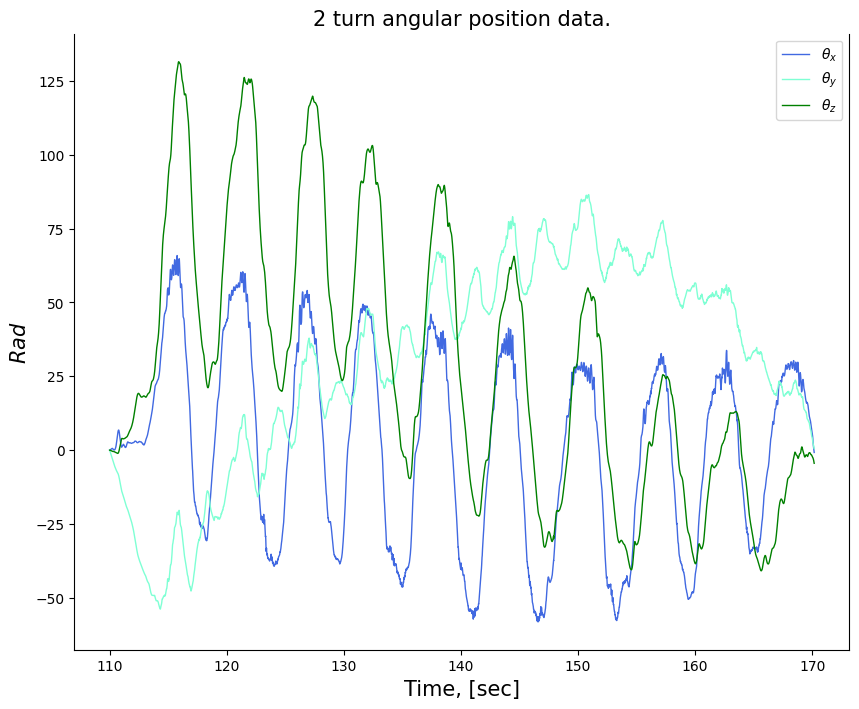

In [24]:
# Simple Plots
f_size = 15
fig, ax = plt.subplots(1,1,figsize=[10,8])
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(ang_acc[0].time_imu,ang_acc[0].x_theta, '-', color='royalblue', linewidth=1, label=r'$\theta_x$')
ax.plot(ang_acc[0].time_imu,ang_acc[0].y_theta, '-', color='aquamarine', linewidth=1, label=r'$\theta_y$')
ax.plot(ang_acc[0].time_imu,ang_acc[0].z_theta, '-', color='green', linewidth=1, label=r'$\theta_z$')
# ax.set_xlim(113,120)

ax.legend(facecolor='white')
ax.set_title('2 turn angular position data.',fontsize=f_size)
ax.set_xlabel('Time, [sec]',fontsize=f_size)
ax.set_ylabel(r'$Rad$',fontsize=f_size)
ax.spines['top'].set_visible(False)
plt.show()

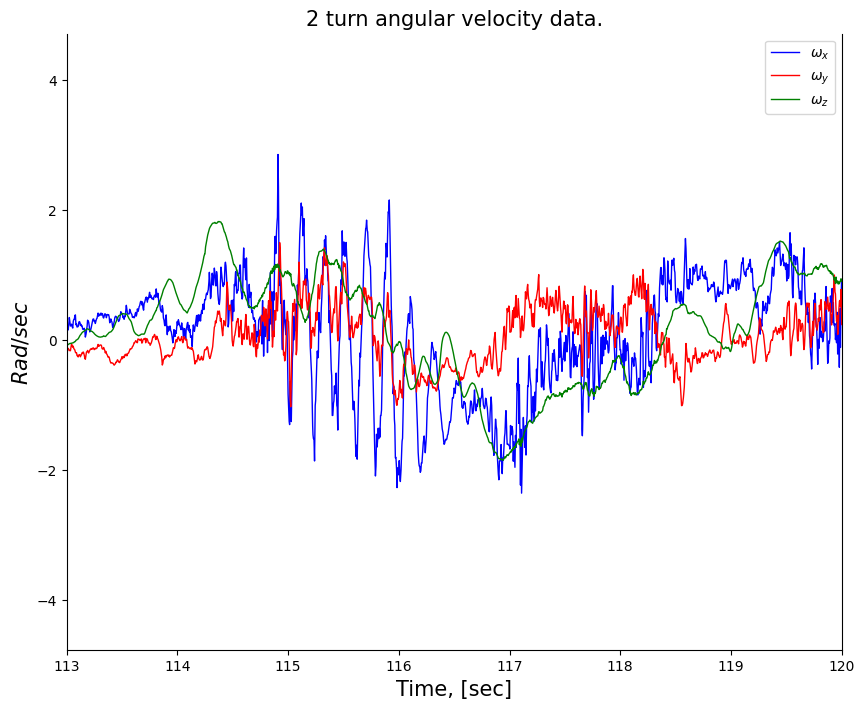

In [25]:
# Simple Plots
xlim = [113,120]
f_size = 15
fig, ax = plt.subplots(1,1,figsize=[10,8])
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(ang_acc[0].time_imu,ang_acc[0].imu_wx*deg_to_rad, '-', color='blue', linewidth=1, label=r'$\omega_x$')
ax.plot(ang_acc[0].time_imu,ang_acc[0].imu_wy*deg_to_rad, '-', color='red', linewidth=1, label=r'$\omega_y$')
ax.plot(ang_acc[0].time_imu,ang_acc[0].imu_wz*deg_to_rad, '-', color='green', linewidth=1, label=r'$\omega_z$')
ax.set_xlim(xlim)

ax.legend(facecolor='white')
ax.set_title('2 turn angular velocity data.',fontsize=f_size)
ax.set_xlabel('Time, [sec]',fontsize=f_size)
ax.set_ylabel(r'$Rad/sec$',fontsize=f_size)
ax.spines['top'].set_visible(False)
plt.show()

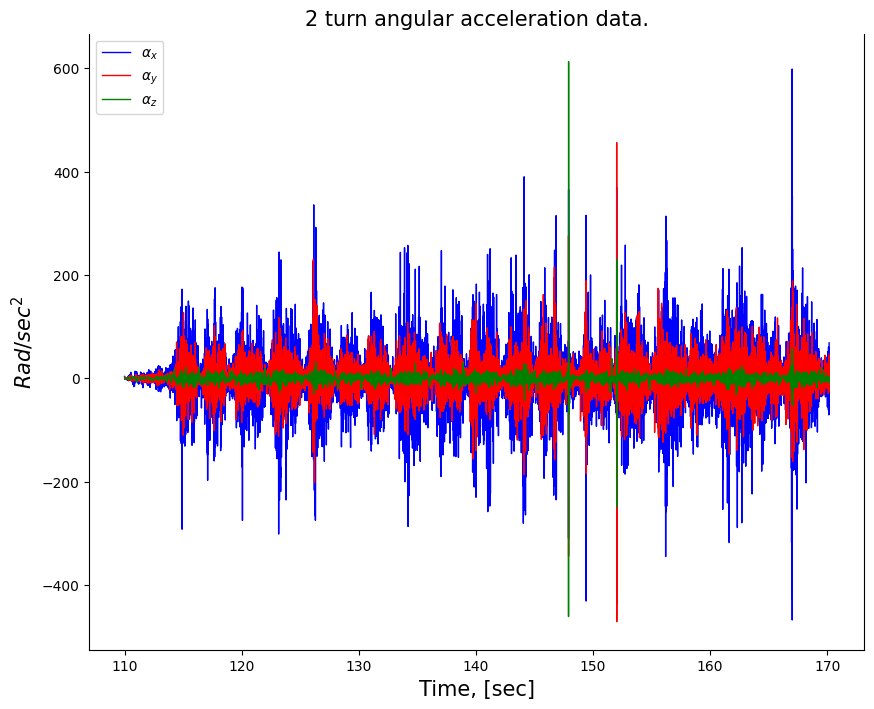

In [26]:
# Simple Plots
xlim = [113,120]
f_size = 15
fig, ax = plt.subplots(1,1,figsize=[10,8])
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')
ax.plot(ang_acc[0].time_imu,ang_acc[0].imu_wx_dt*deg_to_rad, '-', color='blue', linewidth=1, label=r'$\alpha_x$')
ax.plot(ang_acc[0].time_imu,ang_acc[0].imu_wy_dt*deg_to_rad, '-', color='red', linewidth=1, label=r'$\alpha_y$')
ax.plot(ang_acc[0].time_imu,ang_acc[0].imu_wz_dt*deg_to_rad, '-', color='green', linewidth=1, label=r'$\alpha_z$')

# ax.set_xlim(xlim)

ax.legend(facecolor='white')
ax.set_title('2 turn angular acceleration data.',fontsize=f_size)
ax.set_xlabel('Time, [sec]',fontsize=f_size)
ax.set_ylabel(r'$Rad/sec^2$',fontsize=f_size)
ax.spines['top'].set_visible(False)
plt.show()

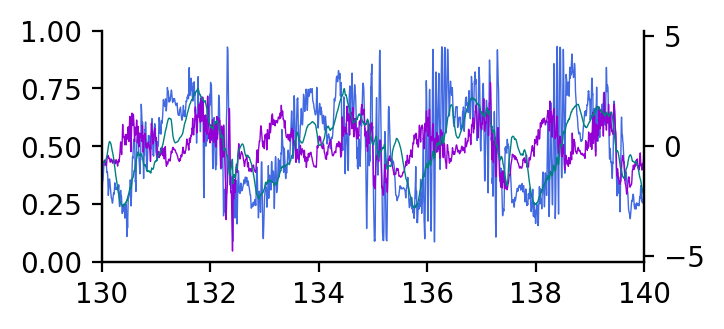

In [31]:
# Simple Plots
xlim = [130,140]
lw = 0.5
run = 8
f_size = 8
fig, ax = plt.subplots(1,1,figsize=[3.5,1.5],dpi=200)
ax1 = ax.twinx()
fig.subplots_adjust(hspace=0.2)
fig.patch.set_facecolor('white')

if 0:
    ax.plot(ang_acc[0].time_imu,ang_acc[run].torque_x, '-', color='royalblue', linewidth=lw, label=r'$\tau_x$')
    ax.plot(ang_acc[0].time_imu,ang_acc[run].torque_y, '-', color='darkviolet', linewidth=lw, label=r'$\tau_y$')
    ax.plot(ang_acc[0].time_imu,ang_acc[run].torque_z, '-', color='teal', linewidth=lw, label=r'$\tau_z$')
    ax.axvspan(xlim[0], xlim[1], color='magenta', alpha=.08, zorder=-1)

else:
    ax1.plot(ang_acc[0].time_imu,ang_acc[run].imu_wx_hat*deg_to_rad, '-', color='royalblue', linewidth=lw, label=r'$\omega_x$')
    ax1.plot(ang_acc[0].time_imu,ang_acc[run].imu_wy_hat*deg_to_rad, '-', color='darkviolet', linewidth=lw, label=r'$\omega_y$')
    ax1.plot(ang_acc[0].time_imu,ang_acc[run].imu_wz_hat*deg_to_rad, '-', color='teal', linewidth=lw, label=r'$\omega_z$')
ax.set_xlim(xlim)
ax1.set_xlim(xlim)
# ax.legend(loc='upper right',facecolor='white')
# ax1.legend(loc='lower right', facecolor='white')
# ax.set_title('Slushy',fontsize=f_size)
# ax.set_xlabel('Time, [sec]',fontsize=f_size)
# ax.set_ylabel('Torque N*m',fontsize=f_size)
# ax1.set_ylabel('Rad/sec', fontsize=f_size)
ax.spines['top'].set_visible(False)
ax1.spines['top'].set_visible(False)
# plt.savefig("torques_zoomed_in.svg",bbox_inches='tight',dpi=fig.dpi)
plt.show()

In [32]:
import figurefirst as fifi

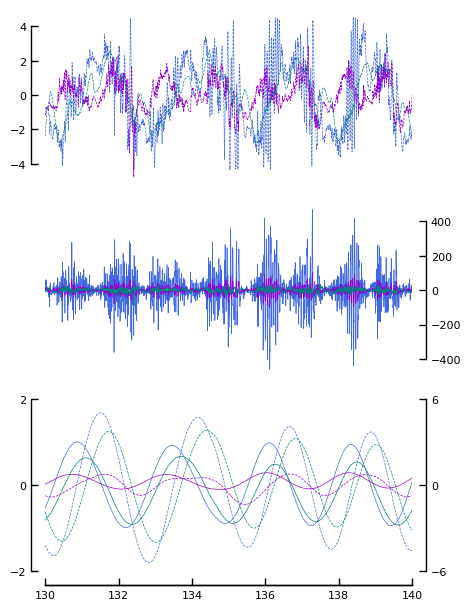

In [90]:
layout = fifi.svg_to_axes.FigureLayout('Fig_torque_angvel.svg', 
                                       autogenlayers=True, make_mplfigures=True, hide_layers=[])



# Ang Vel
ax = layout.axes[('angvel_and_torque', 'angvel')]

xlim = [130,140]
lw = 0.5
run = 8

ax.plot(ang_acc[0].time_imu,ang_acc[run].imu_wx_hat*deg_to_rad, '--', color='royalblue', linewidth=lw, label=r'$\omega_x$')
ax.plot(ang_acc[0].time_imu,ang_acc[run].imu_wy_hat*deg_to_rad, '--', color='darkviolet', linewidth=lw, label=r'$\omega_y$')
ax.plot(ang_acc[0].time_imu,ang_acc[run].imu_wz_hat*deg_to_rad, '--', color='teal', linewidth=lw, label=r'$\omega_z$')

ax.set_xlim(xlim)
ax.set_ylim(-5,5)
fifi.mpl_functions.adjust_spines(ax, ['left'], yticks=[-4, -2, 0, 2, 4])
fifi.mpl_functions.set_fontsize(ax, 8)


# Torque
ax = layout.axes[('angvel_and_torque', 'torque')]

xlim = [130,140]
lw = 0.5
run = 8

ax.plot(ang_acc[0].time_imu,ang_acc[run].torque_x, '-', color='royalblue', linewidth=lw, label=r'$\tau_x$')
ax.plot(ang_acc[0].time_imu,ang_acc[run].torque_y, '-', color='darkviolet', linewidth=lw, label=r'$\tau_y$')
ax.plot(ang_acc[0].time_imu,ang_acc[run].torque_z, '-', color='teal', linewidth=lw, label=r'$\tau_z$')

ax.set_xlim(xlim)
ax.set_ylim(-500, 500)
fifi.mpl_functions.adjust_spines(ax, ['right'], yticks=[-400, -200, 0, 200, 400])
fifi.mpl_functions.set_fontsize(ax, 8)




# Smooth comparison

smooth_params = [3, 0.001]
angvel_x_smooth, _ = pynumdiff.smooth_finite_difference.butterdiff(ang_acc[run].imu_wx_hat*deg_to_rad, 
                                                                   dt, smooth_params)
angvel_y_smooth, _ = pynumdiff.smooth_finite_difference.butterdiff(ang_acc[run].imu_wy_hat*deg_to_rad, 
                                                                   dt, smooth_params)
angvel_z_smooth, _ = pynumdiff.smooth_finite_difference.butterdiff(ang_acc[run].imu_wz_hat*deg_to_rad, 
                                                                   dt, smooth_params)


torq_x_smooth, _ = pynumdiff.smooth_finite_difference.butterdiff(ang_acc[run].torque_x, 
                                                                   dt, smooth_params)
torq_y_smooth, _ = pynumdiff.smooth_finite_difference.butterdiff(ang_acc[run].torque_y, 
                                                                   dt, smooth_params)
torq_z_smooth, _ = pynumdiff.smooth_finite_difference.butterdiff(ang_acc[run].torque_z, 
                                                                   dt, smooth_params)

ax = layout.axes[('angvel_and_torque', 'combo')]
ax1 = ax.twinx()

xlim = [130,140]
lw = 0.5
run = 8

ax.plot(ang_acc[0].time_imu,angvel_x_smooth, '--', color='royalblue', linewidth=lw, label=r'$\tau_x$')
ax1.plot(ang_acc[0].time_imu,torq_x_smooth, '-', color='royalblue', linewidth=lw, label=r'$\tau_x$')

ax.plot(ang_acc[0].time_imu,angvel_y_smooth, '--', color='darkviolet', linewidth=lw, label=r'$\tau_x$')
ax1.plot(ang_acc[0].time_imu,torq_y_smooth, '-', color='darkviolet', linewidth=lw, label=r'$\tau_x$')

ax.plot(ang_acc[0].time_imu,angvel_z_smooth, '--', color='teal', linewidth=lw, label=r'$\tau_x$')
ax1.plot(ang_acc[0].time_imu,torq_z_smooth, '-', color='teal', linewidth=lw, label=r'$\tau_x$')

#ax.vlines([133.45,136.1], -4, 4)
#ax.vlines([134.15], -4, 4, linestyles=['--'])

ax.set_xlim(xlim)
ax.set_ylim(-2,2)
ax1.set_ylim(-6, 6)
fifi.mpl_functions.adjust_spines(ax, ['bottom', 'left'], yticks=[-2, 0, 2])#, xticks=[130, 140])
fifi.mpl_functions.adjust_spines(ax1, ['bottom', 'right'], yticks=[-6, 0, 6])
fifi.mpl_functions.set_fontsize(ax, 8)
fifi.mpl_functions.set_fontsize(ax1, 8)

In [56]:
layout.append_figure_to_layer(layout.figures['angvel_and_torque'], 'angvel_and_torque', cleartarget=True)
layout.write_svg('Fig_torque_angvel.svg')